The goal of this pre-processing file is to determine what filter and parameters are most likely to make it easier to segment the dataset

In [ ]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os

# mount drive- following tutorial at https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674
from google.colab import drive
drive.mount('/content/drive')
 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


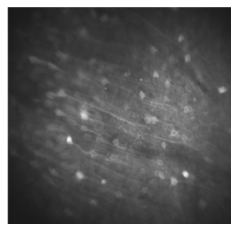

In [ ]:
# import image

im_dir='drive/My Drive/CHEME 599/Project/images'; # image path to open

images = []
i=0;
for fname in os.listdir(im_dir):
  im=plt.imread(os.path.join(im_dir, fname)); # read image 
  images=([images, im]) # still not working 
  


fig, ax=plt.subplots(figsize=(4,4)) # prepare plot of image
ax.imshow(im.astype('uint8'))  # plot the image
ax.axis('off'); # remove axis labels, semicolon suppresses text output 

In [ ]:
from skimage import color
im=color.rgb2gray(im) 
print(im.shape)

(316, 325)


/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


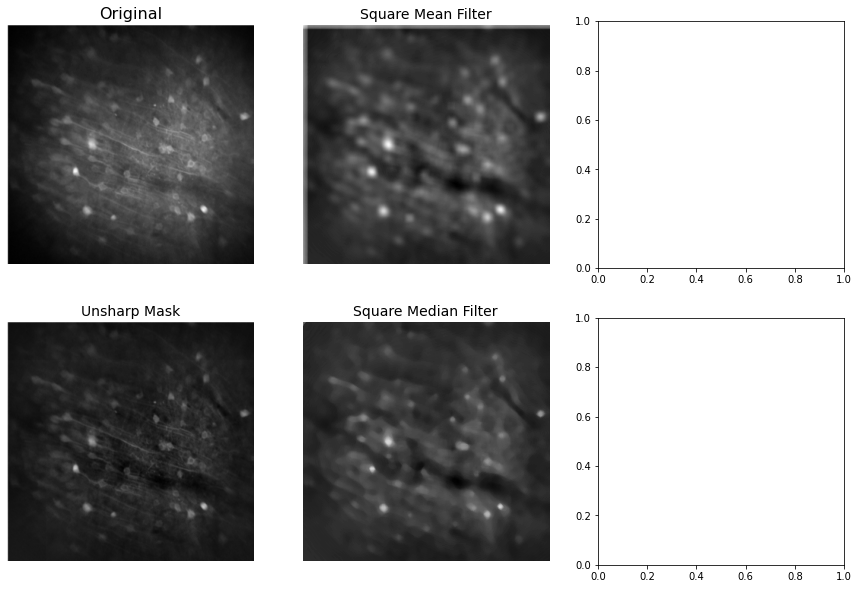

In [96]:
# test spatial filters
from skimage.morphology import square, disk, star
from skimage.filters import rank
from skimage.util import img_as_float, img_as_ubyte

def unsharp_mask(im):  
    im=img_as_ubyte(im)
    selem2=square(100)
    background=1.0*rank.mean(im, selem2)
    im_us=im-background
  
    imin = np.min(im_us) #custom rescaling
    imax = np.max(im_us)
    full = imax - imin
    im_us = np.round(255*(im_us - imin)/full, 0)
    return(im_us)

im_us=unsharp_mask(im)
im_float=img_as_float(im)
selem=square(10) # make a 10x10 square of ones 
im_mean=unsharp_mask(rank.mean(im_float, selem=selem)) # create image filtered with square mean spatial filter
im_med=unsharp_mask(rank.median(im_float, selem=selem)) # create image filtered with square median spatial filter 


fig, ax=plt.subplots(figsize=(15, 10) , ncols=3, nrows=2)


ax[0,0].imshow(im, cmap='gray')
ax[0,0].set_title('Original',fontsize=16)
ax[0,0].axis('off')

ax[1,0].imshow(im_us, cmap='gray')
ax[1,0].set_title('Unsharp Mask', fontsize=14)
ax[1,0].axis('off');

ax[0,1].imshow(im_mean, cmap='gray')
ax[0,1].set_title('Square Mean Filter',fontsize=14)
ax[0,1].axis('off')

ax[1,1].imshow(im_med, cmap='gray')
ax[1,1].set_title('Square Median Filter', fontsize=14)
ax[1,1].axis('off');





In [119]:
# test frequency filters 
import scipy as sp # needed for fft

def frequency_filter(im,filt):
  # perform fft 
  f_im=sp.fft.fft2(im)
  # center
  f_im2=sp.fft.fftshift(f_im)
  #multiply by a filter function
  f_im3=np.multiply(f_im2, filt) 
  #un-center
  f_im4=sp.fft.ifftshift(f_im3)
  # perform inverse fft
  im_fft=np.real(sp.fft.ifft2(f_im4)) # possible to have imaginary component-- use real to remove this
  return im_fft

def gaussian_filter(im,divisor):
  xi=np.linspace(0,im.shape[1]-1,im.shape[1])
  yi=np.linspace(0,im.shape[0]-1,im.shape[0])
  x,y=np.meshgrid(xi,yi) # need to make sure filter is same shape as image
  mu, sigmaHi, sigmaLo= im.shape[0]/divisor, im.shape[0]/divisor, im.shape[0]/(10*divisor) # bigger sigma = bigger
  gfilt=np.exp(-((x-mu)**2+(y-mu)**2)/(2*sigmaHi**2)) # remove high frequency 
  gfilt2=1-np.exp(-((x-mu)**2+(y-mu)**2)/(2*sigmaLo**2)) # remove low frequency 
  
  imHi=frequency_filter(im, gfilt)
  imLo=frequency_filter(im, gfilt2)

  fig, ax=plt.subplots(figsize=(10, 10) , ncols=2, nrows=2)
  ax[0,0].imshow(gfilt, cmap='gray')
  ax[0,0].axis('off')
  ax[0,0].set_title('High Pass Filter')
  ax[0,1].imshow(gfilt2, cmap='gray')
  ax[0,1].axis('off')
  ax[0,1].set_title('Low Pass Filter')
  ax[1,0].imshow(imHi,cmap='gray')
  ax[1,0].axis('off')
  ax[1,0].set_title('High Pass Filtered Image')
  ax[1,1].imshow(imLo,cmap='gray')
  ax[1,1].axis('off')
  ax[1,1].set_title('Low Pass Filtered Image')
  
  return imHi, imLo


def butterwoth_filter(im, order, D0, hipass):
  n, D0= order, D0
  xi=np.linspace(0,im.shape[1]-1,im.shape[1])
  yi=np.linspace(0,im.shape[0]-1,im.shape[0])
  x,y=np.meshgrid(xi,yi) # need to make sure filter is same shape as image
  D=np.sqrt((x-im.shape[1]/2)**2+(y-im.shape[0]/2)**2)
  if hipass==0:
    bfilt=1-1/(1+(D/D0)**(2*n))
  else:
    bfilt=1/(1+(D/D0)**(2*n))
  
  imB=frequency_filter(im, bfilt)
  fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
  ax[0].imshow(bfilt, cmap='gray')
  ax[0].set_title('Butterworth Filter')
  ax[1].imshow(imB, cmap='gray')
  ax[1].set_title('Butterworth Filtered Image')
  for axi in ax:
    axi.axis('off')

  return imB


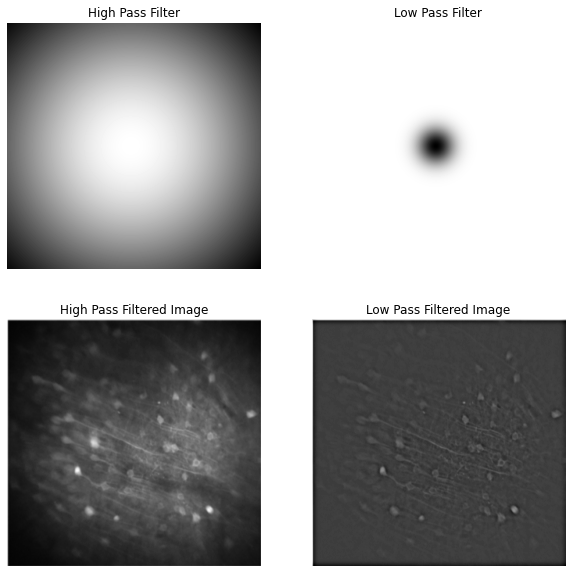

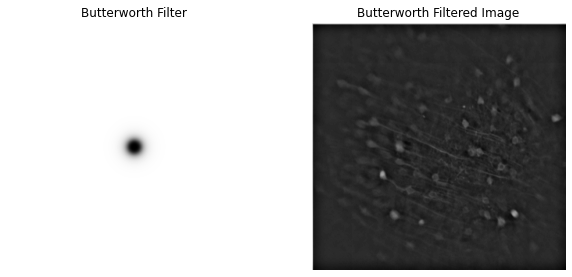

In [121]:

(imHi, imLo)=gaussian_filter(im, 2)
imB=butterwoth_filter(im_us, 2, 10, 0)